In [223]:
import requests
import pandas as pd
import io
import time
import API_info#file to keep your API key
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Some things we need to access the Enigma API

In [224]:
headers = {'authorization': 'Bearer '+API_info.API_key}
base_url = "https://public.enigma.com/api/"

# Define a function to get data from the Enigma API

In [225]:
def getEnigmaData(dataid):
    #Get the dataset current snapshot
    url = base_url + 'datasets/{}'.format(dataid)
    response = requests.get(url, headers=headers)
    json = response.json()
    snapshot_id = json['current_snapshot']['id']#get most recent snapshot of dataset

    #Get the dataset
    url = base_url + 'export/{}'.format(snapshot_id)
    print('Reading data from Enigma API to pandas...')
    startread=time.time()
    response = requests.get(url, headers=headers).content
    print('Read took '+str(time.time()-startread)+' seconds.')
    return pd.read_csv(io.StringIO(response.decode('utf-8')))

def readEnigmaCSV(path,colids=None):
    if colids:
        return pd.read_csv(path,usecols=colids)
    else:
        return pd.read_csv(path)
    

# I'm going to focus on the relationship between drug type, disease type, medicare spending and how much we're spending on drugs with known adverse effects

## To do this, I'm going to use the FDA adverse events dataset and the medicare drug spending dataset

In [226]:
##########Access Enigma Public Through Pandas#############
##########Some dataset ids of interest####################
#dataset_id = 'fa7ab996-fb43-4e86-80e7-f8e82ccba15f'
#dataset_id = 'a4fecc00-1442-4b3c-b6d5-5866feb95f8b'#Medicare drug spending 2010-2015
#dataset_id = '7f824984-adcb-4fb9-a481-00ecd3d9f0cb'#Health Interview Survey 2012
#dataset_id = 'cd65e860-1269-4ab7-9b37-788110f81f27' Adverse Events 2015
#dataset_id_advevents = 'd6bad17f-ee0b-4f3d-9fa0-bb85cd7e68c0'#Curated FDA adverse events 2016
##########Some dataset ids of interest####################
useAPI=False
if useAPI:#Get data directly through Enigma API
    dataset_id_advevents = 'cd65e860-1269-4ab7-9b37-788110f81f27'#Curated FDA adverse events 2015
    dfAdvEvents = getEnigmaData(dataset_id_advevents)
    #dataset_id_advevents2015='cd65e860-1269-4ab7-9b37-788110f81f27'
    #dfAdvEvents2015 = getEnigmaData(dataset_id_advevents2015)
    dataset_id_medspend = 'a4fecc00-1442-4b3c-b6d5-5866feb95f8b'#Medicare drug spending 2010-2015
    dfMedSpend = getEnigmaData(dataset_id_medspend)
else:#Load data from pre-downloaded CSV (did this when I realized I exceeded Enigma's 80 API export calls/month)
    advEventsCols=['primaryid', 'caseid', 'drug_seq', 'role_cod', 'drugname','indi_pt','pt','age','sex','wt',
                   'outc_cod_definition']
    print('Loading CSVs...')
    startload=time.time()
    advEventsPath2016=os.getcwd()+'/data/13c21ff0-adf7-470b-b7f9-a0af8c913c66_CuratedFDAAdverseEvents-2016.csv'
    dfAdvEvents2016=readEnigmaCSV(advEventsPath2016,colids=advEventsCols)#,colids=advEventsCols
    advEventsPath2015=os.getcwd()+'/data/0441e88c-bbe6-41e3-9156-c95f6dcca95c_CuratedFDAAdverseEvents-2015.csv'
    dfAdvEvents2015=readEnigmaCSV(advEventsPath2015,colids=advEventsCols)#,colids=advEventsCols
    medspendpath=os.getcwd()+'/data/23165ea4-6da5-4119-be25-bcf2d09fbee5_MedicareDrugSpending-2010-2015.csv'
    dfMedSpend=readEnigmaCSV(medspendpath,colids=None)
    print('CSV load took '+str(time.time()-startload)+' seconds')
    frames=[dfAdvEvents2015,dfAdvEvents2016]
    dfAdvEvents=pd.concat(frames,ignore_index=True)
    sizeBeforeDropDups=dfAdvEvents.shape[0]
    dfAdvEvents.drop_duplicates(inplace=True)#Let's get rid of duplcates that may have occurred in 2015-2016
    print('Found '+str(sizeBeforeDropDups-dfAdvEvents.shape[0])+' duplicates.')
print(dfAdvEvents.keys())
print(dfMedSpend.keys())

Loading CSVs...
CSV load took 26.7289559841156 seconds
Found 5897 duplicates.
Index(['primaryid', 'caseid', 'drug_seq', 'role_cod', 'drugname', 'indi_pt',
       'age', 'sex', 'wt', 'pt', 'outc_cod_definition'],
      dtype='object')
Index(['year', 'brand_name', 'generic_name', 'coverage_type', 'total_spending',
       'beneficiary_count', 'unit_count', 'beneficiary_cost_share',
       'total_annual_spending_per_user', 'average_cost_per_unit',
       'average_annual_beneficiary_cost_share', 'claim_count',
       'beneficiary_count_lis', 'beneficiary_count_no_lis',
       'beneficiary_cost_share_lis', 'beneficiary_cost_share_no_lis',
       'average_beneficiary_cost_share_lis',
       'average_beneficiary_cost_share_no_lis'],
      dtype='object')


Index(['year', 'brand_name', 'generic_name', 'coverage_type', 'total_spending',
       'beneficiary_count', 'unit_count', 'beneficiary_cost_share',
       'total_annual_spending_per_user', 'average_cost_per_unit',
       'average_annual_beneficiary_cost_share', 'claim_count',
       'beneficiary_count_lis', 'beneficiary_count_no_lis',
       'beneficiary_cost_share_lis', 'beneficiary_cost_share_no_lis',
       'average_beneficiary_cost_share_lis',
       'average_beneficiary_cost_share_no_lis'],
      dtype='object')


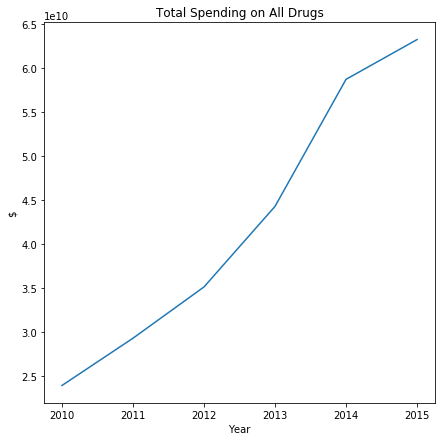

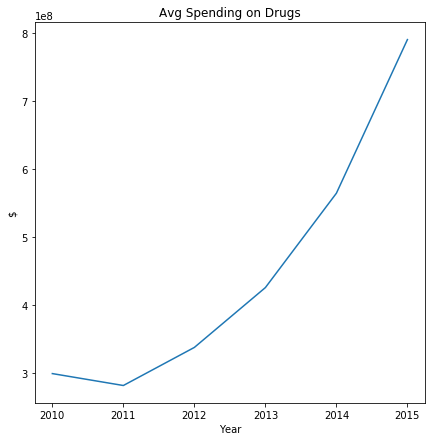

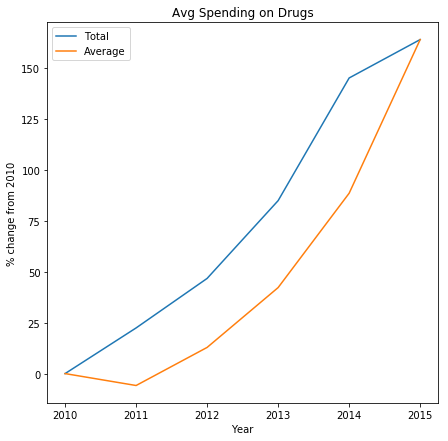

In [227]:
print(dfMedSpend.keys())
medspendyeartotal=dfMedSpend.groupby('year').sum()
medspendyearavg=dfMedSpend.groupby('year').mean()
plt.figure(figsize=(7,7))
plt.plot(medspendyeartotal['total_spending'])
plt.title('Total Spending on All Drugs')
plt.xlabel('Year')
plt.ylabel('$')
plt.show()

plt.figure(figsize=(7,7))
plt.plot(medspendyearavg['total_spending'])
plt.title('Avg Spending on Drugs')
plt.xlabel('Year')
plt.ylabel('$')
plt.show()

#let's plot each of these as % change from 2010 to see how the shapes of the curves differ
plt.figure(figsize=(7,7))
plt.plot(100*(medspendyeartotal['total_spending']/medspendyeartotal['total_spending'][2010])-100,label='Total')
plt.title('Total Spending on All Drugs')
plt.xlabel('Year')
plt.ylabel('$')
plt.plot(100*(medspendyearavg['total_spending']/medspendyearavg['total_spending'][2010])-100,label='Average')
plt.title('Avg Spending on Drugs')
plt.xlabel('Year')
plt.ylabel('% change from 2010')
plt.legend()
plt.show()

# How does Medicare spending on drugs that were found to have adverse events in 2015/2016 compare to those without in 2010-2015?

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
40
42
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


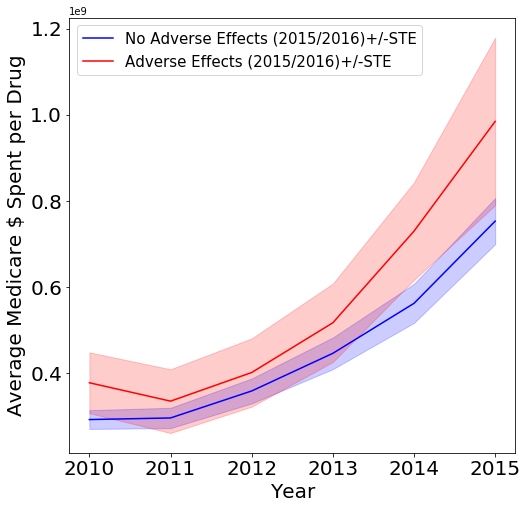

Ratio of spending for drugs without adverse effect/with adverse effects by year:
2010:1.29307515515
2011:1.13216869219
2012:1.11966813571
2013:1.15920417295
2014:1.29863808515
2015:1.30777807817


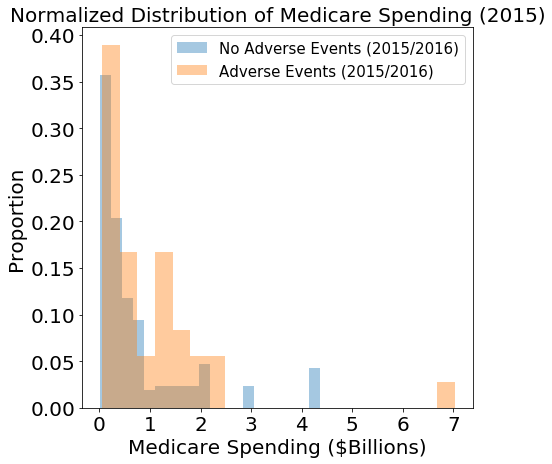

RanksumsResult(statistic=-2.0290673557864465, pvalue=0.042451430305581142)

In [230]:
import math
from scipy import stats
import numpy
#check which bran name drugs are also included in the adverse drug data
#check which generic drugs are also included in the adverse drug data
#drugsincommon=sorted(list(set(list(dfAdvEvents.drugname)) & set(list(dfMedSpend.generic_name.append(dfMedSpend.brand_name)))))
allDrugsMedicare=list(dfMedSpend.generic_name)#+list(dfMedSpend.brand_name)
drugsincommon=sorted(list(set(list(dfAdvEvents.drugname)) & set(allDrugsMedicare)))
print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
print(len(list(set(list(dfAdvEvents.drugname)) & set(allDrugsMedicare))))
print(len(list(set(list(dfAdvEvents.drugname)) & set(list(dfMedSpend.generic_name)+list(dfMedSpend.brand_name)))))
print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
drugsnotincommon=[x for x in list(dfMedSpend.generic_name) if x not in drugsincommon]
#print(sorted(drugsincommon))
#print(sorted(drugsnotincommon))
#dfMedSpend.generic_name.append(dfMedSpend.brand_name)


groupdrugspend=dfMedSpend.groupby(['year','generic_name'])['total_spending'].sum()
groupagespend=dfMedSpend.groupby(['year','generic_name']).sum().keys()

f = plt.figure(figsize=(8,8))
incommonmean=groupdrugspend.unstack()[drugsincommon].T.mean()
#calculate the standard error
incommonste=groupdrugspend.unstack()[drugsincommon].T.std()/math.sqrt(groupdrugspend.unstack()[drugsincommon].T.shape[0])
notincommonmean=groupdrugspend.unstack()[drugsnotincommon].T.mean()
#calculate the standard error
notincommonste=groupdrugspend.unstack()[drugsnotincommon].T.std()/math.sqrt(groupdrugspend.unstack()[drugsnotincommon].T.shape[0])
plt.fill_between(notincommonste.index, notincommonmean-notincommonste, notincommonmean+notincommonste, color='b', alpha=0.2)
plt.fill_between(incommonste.index, incommonmean-incommonste, incommonmean+incommonste, color='r', alpha=0.2)
groupdrugspend.unstack()[drugsnotincommon].T.mean().plot(ax=f.gca(),color='b',label='No Adverse Effects (2015/2016)+/-STE')
groupdrugspend.unstack()[drugsincommon].T.mean().plot(ax=f.gca(),color='r',label='Adverse Effects (2015/2016)+/-STE')
plt.ylabel('Average Medicare $ Spent per Drug',fontsize=20)
plt.xlabel('Year',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15,loc='upper left')
plt.show()
ratioAdvNoAdv=list()
for i in range(2010,2016):
    ratioAdvNoAdv.append(incommonmean[i]/notincommonmean[i])
print('Ratio of spending for drugs without adverse effect/with adverse effects by year:')
for i in range(2010,2016):
    print(str(i)+':'+str(incommonmean[i]/notincommonmean[i]))

groupdrugspend.unstack()[drugsincommon].T[2015].values.shape
#Let's see if there is a significant difference in spending in 2015 between drugs found to have adverse effects vs those that don't
notincommonforttest = groupdrugspend.unstack()[drugsnotincommon].T[2015].values[~numpy.isnan(groupdrugspend.unstack()[drugsnotincommon].T[2015].values)]
incommonforttest = groupdrugspend.unstack()[drugsincommon].T[2015].values[~numpy.isnan(groupdrugspend.unstack()[drugsincommon].T[2015].values)]
plt.figure(figsize=(7,7))

weightsnotincommon = np.ones_like(notincommonforttest)/float(len(notincommonforttest))
weightsincommon = np.ones_like(incommonforttest)/float(len(incommonforttest))

plt.hist(notincommonforttest/1e9,weights=weightsnotincommon,alpha=0.4,bins=20,label='No Adverse Events (2015/2016)')
plt.hist(incommonforttest/1e9,weights=weightsincommon,alpha=0.4,bins=20,label='Adverse Events (2015/2016)')
plt.title('Normalized Distribution of Medicare Spending (2015)',fontsize=20)
plt.xlabel('Medicare Spending ($Billions)',fontsize=20)
plt.ylabel('Proportion',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.show()
stats.ranksums(notincommonforttest,incommonforttest)

# Medicare spent on average ~30% more on drugs found to have adverse effects than those which weren't found to have adverse effects in 2015, and the trends seems to be climbing...

## I should mention that this measure is biased however...drugs with adverse events in 2015/2016 could be newer drugs that patients are trying out of desperation.  Therefore, they may not have existed (or been less accessible) in 2010-2014

# Could Medicare have used drugs with less adverse effects instead?  Would this have improved patient outcomes and would it have saved money?

## Let's see if we can take the most severe adverse outcomes (i.e. those that result in death) and use a different drug

In [ ]:
#Let's see if we can find drugs for the same indication without adverse effects
#indipt_incommon=dfMedSpend[dfMedSpend['generic_name'].isin(drugsincommon)]#['coverage_type']
#print(indipt_incommon.keys())
'''
print(dfAdvEvents.keys())
for i in dfAdvEvents['pt']:
     print(i)
        
for i in dfAdvEvents:
    if 'death' in i.lower():
        print(i)
'''
print(len(dfAdvEvents.drugname))
print(len(set(dfAdvEvents.drugname)))
print(len(dfAdvEvents.drugname)/len(set(dfAdvEvents.drugname)))
print(dfAdvEvents.keys())
dfAdvEventsDict=dfAdvEvents.to_dict()
print(dfAdvEventsDict)

5458779
134180
40.682508570576836
Index(['primaryid', 'caseid', 'drug_seq', 'role_cod', 'drugname', 'indi_pt',
       'age', 'sex', 'wt', 'pt', 'outc_cod_definition'],
      dtype='object')


In [85]:
mergedEventsSpend = pd.merge(dfAdvEvents,dfMedSpend, left_on='drugname',right_on=['generic_name'])
mergedEventsSpend
#print(mergedEventsSpend['outc_cod_definition'])
print(mergedEventsSpend.shape)

(15197, 81)


# Let's see how type of disease influences spending first

In [86]:
#indi_pt=indicated preferred term
groupSpendIndi=mergedEventsSpend.groupby(['indi_pt','outc_cod_definition','drugname']).mean()[['total_spending','age','wt','average_cost_per_unit','total_annual_spending_per_user']]#['total_annual_spending_per_user']
#print(groupSpendIndi.loc['Acute lymphocytic leukaemia','Death']) 
#print(list(groupSpendIndi.index.levels[1]))
#print(groupSpendIndi.index)
#print(groupSpendIndi)#[['age','wt','average_cost_per_unit']])
#groupSpendIndi.unstack(level=0).plot(kind='bar')
#print(groupSpendIndi.groupby(level=[0,1]).nlargest(10))
#groupSpendIndi
#plt.bar(np.arange(0,len(groupSpendIndi)),sorted(groupSpendIndi))
counter=0
'''
for i in list(groupSpendIndi.index.levels[0]):
    for j in list(groupSpendIndi.index.levels[1]):
        print(j)
        
        try:
            plt.plot(counter,groupSpendIndi.loc[i,'Death']['total_spending'],'ob')
            plt.plot(counter,groupSpendIndi.loc[i,'Life-Threatening']['total_spending'],'or')
            #counter+=1
        except:
            pass
        counter+=1

    
plt.show()
print(groupSpendIndi.index.levels)
'''
print(groupSpendIndi.shape)

(662, 5)


# Let's take a naive glance at correlations in adverse events and spending

'\nthreshold=0.1\ncorr_vars=list()\nprint(dfMedSpend.corr())\n\nfor i in dfMedSpend.corr().keys():\n    for j in dfMedSpend.corr().index:\n        if dfMedSpend.loc[i,j]>threshold:\n            corr_vars.append([i,j])\n'

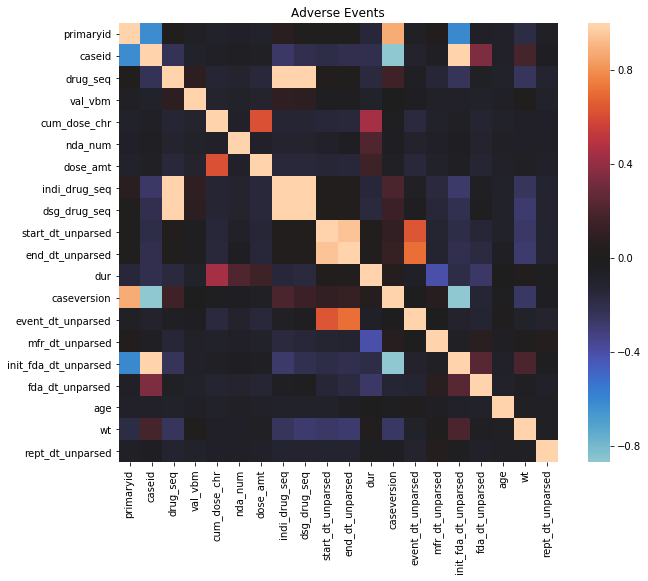

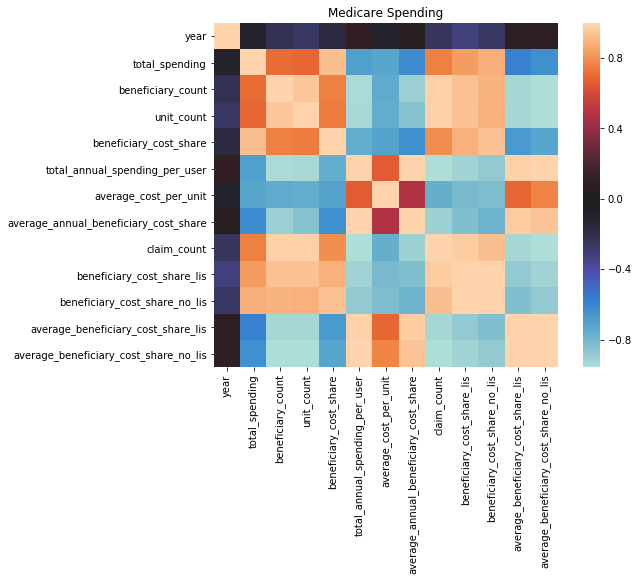

In [206]:

def plot_corr(df,size=18,plottitle=''):

    f, ax = plt.subplots(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr,
                square=True, ax=ax,center=0.0)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(plottitle)
    
plot_corr(dfAdvEvents.corr(),plottitle='Adverse Events')
plot_corr(dfMedSpend.corr(),plottitle='Medicare Spending')
'''
threshold=0.1
corr_vars=list()
print(dfMedSpend.corr())

for i in dfMedSpend.corr().keys():
    for j in dfMedSpend.corr().index:
        if dfMedSpend.loc[i,j]>threshold:
            corr_vars.append([i,j])
'''
